# Redes totalmente convolucionais

Este notebook aborda os seguintes aspectos relacionados às redes totalmente convolucionais:

- como transformar uma camada densa em convolucional, aproveitando seus pesos;
- como criar, a partir de uma rede pré-treinada para classificar imagens, uma rede totalmente convolucional;
- demonstrar que uma rede totalmente convolucional, quando aplicada em imagens maiores que aquelas usadas em seu treinamento, implementa uma varredura implícita com ganhos de eficiência.
- apresentar um método de supressão de não máximo para detectar caracteres

## Motivação

### Rede 2 camadas convolucionais e 2 camadas densas

<img src="https://raw.githubusercontent.com/robertoalotufo/files/master/figures/Rede_LeNet_like.png">
<!-- <img src="../figures/Rede_LeNet_like.png"></a> -->

### Rede equivalente com 4 camadas convolucionais 

<img src="https://raw.githubusercontent.com/robertoalotufo/files/master/figures/Rede_LeNet_like_fully_convolutional.png">
<!--<img src='../figures/Rede_LeNet_like_fully_convolutional.png'></img>-->

In [1]:
REMOTE_COLAB = False
nworkers = 4
if REMOTE_COLAB:
    
    nworkers = 0
    
    # Instalação de bibliotecas e datasets necessários no colab remoto
    print("Verificando instalação do torch e bibliotecas extras necessárias...")
    from os import path
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

    accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

    !pip3 install http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
    print("AGORA REINICIE O KERNEL ANTES DE CONTINUAR!")
    !nvidia-smi

!wget -nc -q https://raw.githubusercontent.com/robertoalotufo/files/master/lib/pytorch_trainer_v2.py -Plib/
!wget -nc -q https://raw.githubusercontent.com/robertoalotufo/files/master/models/lenet-mnist.model -Pmodels/
!wget -nc -q https://raw.githubusercontent.com/robertoalotufo/files/master/models/lenet-mnist.histo -Pmodels/


## Importando os módulos

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

# from torch
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
import torch.nn.functional as F

# from torchvision
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST


In [3]:
from lib import pytorch_trainer_v2 as ptt
device = torch.device('cpu')
if torch.cuda.is_available():
    from torch.cuda import get_device_name
    print(get_device_name(0))
    device = torch.device('cuda')
print('Device available:', device)

Device available: cpu


## Carregando MNIST dataset

In [4]:
dataset_dir = 'data/MNIST/'

# Transformara os dados em tensores no intervalo [0.0, 1.0] (Os dados serão normalizados)
data_transform = transforms.ToTensor()
# data_transform = None

# carrega o conjunto de treinamento e de teste
datasets = dict(train=MNIST(dataset_dir, train=True,  transform=data_transform, download=True),
                val  =MNIST(dataset_dir, train=False, transform=data_transform, download=False))

dataloaders = dict(train=torch.utils.data.DataLoader(dataset=datasets['train'], batch_size=32, shuffle=True),
                   val  =torch.utils.data.DataLoader(dataset=datasets['val'],   batch_size=32, shuffle=False))

print('Amostras para treinamento:', len(datasets['train']))
print('Amostras para validação:',   len(datasets['val']))
print(type(datasets['train'].train_data))
print(datasets['train'].train_data.size())
print(datasets['train'].train_data.min(), datasets['train'].train_data.max())

Amostras para treinamento: 60000
Amostras para validação: 10000
<class 'torch.Tensor'>
torch.Size([60000, 28, 28])
tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)


## Pequena amostra apenas para testar o código

In [5]:
if True:
    n_samples_train = 1000
    n_samples_test  = 500

    datasets['train'].train_data = datasets['train'].train_data[:n_samples_train]
    datasets['train'].train_labels = datasets['train'].train_labels[:n_samples_train]
    datasets['val'].test_data = datasets['val'].test_data[:n_samples_test]
    datasets['val'].test_labels = datasets['val'].test_labels[:n_samples_test]
    
    print('Amostras para treinamento:', len(datasets['train']))
    print('Amostras para validação:', len(datasets['val']))

Amostras para treinamento: 1000
Amostras para validação: 500


## Definição do modelo com camadas densas (igual ao notebook anterior)

In [6]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        
        # Camadas convolucionais
        self.conv_layer = nn.Sequential(OrderedDict([
            # lembrar de usar zero padding para manter o tamanho da imagem
            ('conv1', nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, padding=2)),   
            ('relu1', nn.ReLU()),
            ('max_pool1', nn.MaxPool2d(2)),

            ('conv2', nn.Conv2d(in_channels=20, out_channels=50, kernel_size=5, padding=2)),
            ('relu2', nn.ReLU()),
            ('max_pool2', nn.MaxPool2d(2)),
            
            ('drop', nn.Dropout(p=0.5))
        ]))
        
        # Camadas densas
        self.dense_layer = nn.Sequential(OrderedDict([
            ('dense1', nn.Linear(in_features=2450, out_features=80)),
            ('relu1', nn.ReLU()),
            ('dense2', nn.Linear(in_features=80, out_features=10)),
        ]))
        
    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(-1, 2450)  # Transforma a matriz em vetor
        x = self.dense_layer(x)
        
        return x


## Carregando nosso modelo pré-treinado anteriormente

Iremos converter a rede já treinada no exemplo anterior. Caso a próxima célula deste notebook
der erro, é muito provável que o modelo da rede não foi salvo. Deve-se portanto executar o notebook:

- [lenet-mnist.ipynb](lenet-mnist.ipynb)

In [7]:
model_name = 'models/lenet-mnist.model'
saved_weights = torch.load(model_name, map_location=device)

model_dense = MyModel().to(device)
model_dense.load_state_dict(saved_weights)

In [8]:
preds_dense = ptt.predict_classes_loader(model_dense, dataloaders['val'])

In [9]:
preds = ptt.predict_loader(model_dense, dataloaders['val'])
preds.shape

torch.Size([500, 10])

## Modelo totalmente convolucional equivalente

O modelo seguinte é todo ele convolucional.

A primeira camada densa do modelo tem como entrada um tensor de dimensão 2450, resultante do redimensionamento (via *Flatten*) da saída do *Dropout*, 50x7x7. Esta camada gera uma saída com dimensão 50. Seus pesos têm portanto dimensão 2450x50.

Uma camada convolucional que substitua estas camadas *Flatten* e *Dense* terá como entrada um tensor 50x7x7. Para gerar uma saída 50x1x1, a convolução deve criar 50 mapas com um kernel 7x7 e com borda do tipo 'valid'.

Para substituir a última camada densa, usamos uma convolução com 10 mapas e kernel 1x1.


In [10]:
class MyModelFullyConv(nn.Module):
    def __init__(self):
        super(MyModelFullyConv, self).__init__()
        
        # Camadas convolucionais
        self.conv_layer = nn.Sequential(OrderedDict([
            # lembrar de usar zero padding para manter o tamanho da imagem
            ('conv1', nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, padding=2)),   
            ('relu1', nn.ReLU()),
            ('max_pool1', nn.MaxPool2d(2)),

            ('conv2', nn.Conv2d(in_channels=20, out_channels=50, kernel_size=5, padding=2)),
            ('relu2', nn.ReLU()),
            ('max_pool2', nn.MaxPool2d(2)),
            
            ('conv3', nn.Conv2d(in_channels=50, out_channels=80, kernel_size=7)),
            ('relu3', nn.ReLU()),
            
            ('conv4', nn.Conv2d(in_channels=80, out_channels=10, kernel_size=1)),
        ]))
        
    def forward(self, x):
        x = self.conv_layer(x)        
        return x

### Observando a saida de cada camada

In [11]:
model_conv = MyModelFullyConv().to(device)
x = torch.zeros(1, 1, 28, 28).to(device)

print('{:10}: {}'.format('input', str(x.size())))

for name, layer in model_conv.conv_layer.named_children():
    x = layer(x)
    print('{:10}: {}'.format(name, str(x.size())))

input     : torch.Size([1, 1, 28, 28])
conv1     : torch.Size([1, 20, 28, 28])
relu1     : torch.Size([1, 20, 28, 28])
max_pool1 : torch.Size([1, 20, 14, 14])
conv2     : torch.Size([1, 50, 14, 14])
relu2     : torch.Size([1, 50, 14, 14])
max_pool2 : torch.Size([1, 50, 7, 7])
conv3     : torch.Size([1, 80, 1, 1])
relu3     : torch.Size([1, 80, 1, 1])
conv4     : torch.Size([1, 10, 1, 1])


### comparando o tamanho dos pesos das duas redes

In [12]:
def print_weights_size(weight_dict):
    for name, weight in weight_dict.items():
        print('{:25} -> {}'.format(name, weight.shape))

In [13]:
print('--Pesos no modelo dense--')
print_weights_size(model_dense.state_dict())
print('\n--Pesos no modelo fully convolutional--')
print_weights_size(model_conv.state_dict())

--Pesos no modelo dense--
conv_layer.conv1.weight   -> torch.Size([20, 1, 5, 5])
conv_layer.conv1.bias     -> torch.Size([20])
conv_layer.conv2.weight   -> torch.Size([50, 20, 5, 5])
conv_layer.conv2.bias     -> torch.Size([50])
dense_layer.dense1.weight -> torch.Size([80, 2450])
dense_layer.dense1.bias   -> torch.Size([80])
dense_layer.dense2.weight -> torch.Size([10, 80])
dense_layer.dense2.bias   -> torch.Size([10])

--Pesos no modelo fully convolutional--
conv_layer.conv1.weight   -> torch.Size([20, 1, 5, 5])
conv_layer.conv1.bias     -> torch.Size([20])
conv_layer.conv2.weight   -> torch.Size([50, 20, 5, 5])
conv_layer.conv2.bias     -> torch.Size([50])
conv_layer.conv3.weight   -> torch.Size([80, 50, 7, 7])
conv_layer.conv3.bias     -> torch.Size([80])
conv_layer.conv4.weight   -> torch.Size([10, 80, 1, 1])
conv_layer.conv4.bias     -> torch.Size([10])


## Ajustando os pesos do modelo todo convolucional

In [14]:
w_dense = model_dense.state_dict()
w_conv  = model_conv.state_dict()

# Só precisamos ajustar as dimensões dos pesos das camadas:
# - dense1.weight para o tamanho de conv3.weight
# - dense2.weight para o tamanho de conv4.weight
# As outras camadas serão somente copiadas

# weigths
w_conv['conv_layer.conv1.weight'] = w_dense['conv_layer.conv1.weight']
w_conv['conv_layer.conv2.weight'] = w_dense['conv_layer.conv2.weight']
w_conv['conv_layer.conv3.weight'] = w_dense['dense_layer.dense1.weight'].view(80, 50, 7, 7)
w_conv['conv_layer.conv4.weight'] = w_dense['dense_layer.dense2.weight'].view(10, 80, 1, 1)

# bias
w_conv['conv_layer.conv1.bias'] = w_dense['conv_layer.conv1.bias']
w_conv['conv_layer.conv2.bias'] = w_dense['conv_layer.conv2.bias']
w_conv['conv_layer.conv3.bias'] = w_dense['dense_layer.dense1.bias']
w_conv['conv_layer.conv4.bias'] = w_dense['dense_layer.dense2.bias']

model_conv.load_state_dict(w_conv)

## Verificando se o desempenho é o mesmo

Uma vez que colocamos na rede B os pesos da rede A, precisamos verificar se o desempenho da rede B (totalmente convolucional)
possui o mesmo desempenho da rede A.
Fazermos isso medindo a acurácia das duas redes no conjunto de testes.

In [15]:
preds_conv_img = ptt.predict_classes_loader(model_conv, dataloaders['val'])
preds_conv = torch.squeeze(preds_conv_img)

In [16]:
# Mostra os 10 primeiros elementos preditos
labels = datasets['val'].test_labels

print('{:6}: {}'.format('labels',     labels[:10].numpy()))
print('{:6}: {}'.format('dense', preds_dense[:10].numpy()))
print('{:6}: {}'.format('conv',   preds_conv[:10].numpy()))

labels: [7 2 1 0 4 1 4 9 5 9]
dense : [7 2 1 0 4 1 4 9 5 9]
conv  : [7 2 1 0 4 1 4 9 5 9]


In [17]:
print('Acurácia rede totalmente convolucional: {:.5}%'.format(100.0 *(preds_conv  == labels).sum().float() / labels.shape[0]))
print('Acurácia rede clássica:                 {:.5}%'.format(100.0 *(preds_dense == labels).sum().float() / labels.shape[0]))

Acurácia rede totalmente convolucional: 99.2%
Acurácia rede clássica:                 99.4%


# Aplicando o classificador numa imagem maior que 28x28

In [18]:
# Função para criar uma imagem de teste, maior que 28x28 colocando várias amostras
def make_image(X_test, y_test, M=200, H=28, W=28):
    char_index = np.random.choice(X_test.shape[0], 10, replace=False)
    char_img = [img.reshape(H,W) for img in (X_test)[char_index]]
    char_lab = [y for y in y_test[char_index]]

    image = np.zeros((M, M), np.uint8)
    coords = [(20, 20), (50, 150), (100, 100), (151, 151), (120,30)] # posição das imagens na imagem maior
    xlabel = []
    for k, (i, j) in enumerate(coords):
        image[i:i+H, j:j+W] = char_img[k]
        xlabel.append(char_lab[k])
    return image, coords, xlabel

In [19]:
labels = datasets['val'].test_labels
x_test = datasets['val'].test_data

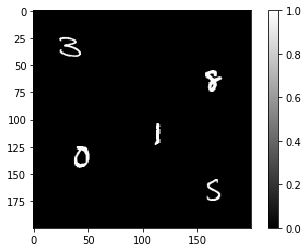

In [20]:
M = 200
image_uint8, coords, xlabel = make_image(x_test.numpy(), labels.numpy(), M) # Construindo uma imagem para testes M x M com 4 dígitos
image = image_uint8/255.
plt.imshow(image, cmap='gray')
plt.colorbar()

## Aplicando classificador na imagem 200 x 200

In [21]:
# transforma imagem de input em Tensor e em seguida a coloca em uma variável
in_image = image.reshape(1, 1, M, M)
in_image = torch.from_numpy(in_image).type(torch.FloatTensor).to(device)
print('{:30}{}'.format('tamanho na entrada:', in_image.size()))
probs = ptt.predict_probas(model_conv, in_image)

output = model_conv(in_image)
po = F.softmax(output,dim=1)
max_pred, max_class = torch.max(po, dim=1)

max_pred_pad = F.pad(max_pred.view(44,44),(3,3,3,3))
print('{:30}{}'.format('tamanho na saída:', max_pred.shape))
print('{:30}{}'.format('tamanho após o padding:', max_pred_pad.shape))

tamanho na entrada:           torch.Size([1, 1, 200, 200])
tamanho na saída:             torch.Size([1, 44, 44])
tamanho após o padding:       torch.Size([50, 50])


In [22]:
hot_map = max_pred_pad.data.cpu().numpy()
print('{:30}{}'.format('tamanho do hot map:', hot_map.shape))

tamanho do hot map:           (50, 50)


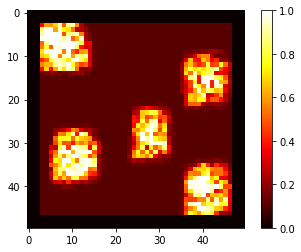

In [23]:
plt.imshow(hot_map, plt.cm.hot)
plt.colorbar()
plt.show()

### Supressão de valores não máximos

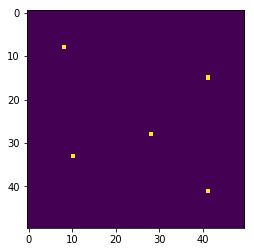

In [24]:
import skimage
from skimage.morphology import square
disk = square(11)
disk[5,5]=0
dil = skimage.morphology.dilation(np.clip(hot_map,0.6,1.0),disk)
cc = hot_map >= dil
plt.imshow(cc)

### Classe identificada em cada máximo

In [25]:
max_class_pad = F.pad(max_class.view(44,44),(3,3,3,3)).data.cpu().numpy()

for r,c in np.transpose(np.nonzero(cc)):
    print(r,c,hot_map[r,c],max_class_pad[r,c])

8 8 0.99999976 3
15 41 0.99999285 8
28 28 0.9999944 1
33 10 1.0 0
41 41 0.99998856 5


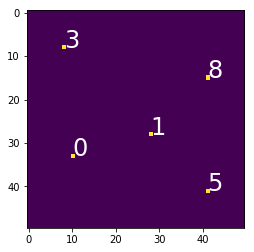

In [26]:
plt.imshow(cc)
for r,c in np.transpose(np.nonzero(cc)):
    plt.text(c,r,max_class_pad[r,c] ,color='white', fontsize=24)
plt.show()

## Observações

- A rede base utilizada não foi treinada para a não-ocorrência de um dos dez caracteres, nem de recortes parciais dos caracteres originais.
- Um exercício interessante seria treinar o modelo com os caracteres sobrepostos a imagens de fundo, além de recortes do fundo sem caracter (11 classes).

## Aprendizados com este notebook
